В данном ноутбуке будут рассмотрены некоторые варианты классификаторов, построенных на основе решающих деревьев.  В некоторых областях, например в кредитном скоринге, существует требование в интерпретируести моделей, что накладывает некоторые ограничения на выбор модели. Одним из основных достоинств является интерпретируемость модели, то есть модель предоставляет некоторый набор правил, каждое из которым понятно людям, ниже будут примеры изображений потобных правил.


Решающие деревья воспроизводят логические схемы, позволяющие
получить окончательное решение о классификации объекта с
помощью ответов на иерархически организованную систему вопросов.
Причём вопрос, задаваемый на последующем иерархическом уровне,
зависит от ответа, полученного на предыдущем уровне. Подобные
логические модели издавна используются в ботанике, зоологии,
минералогии, медицине и других областях. Пример, решающего
дерева, позволяющая грубо оценить стоимость квадратного метра
жилья в предполагаемом городе приведена на рисунке

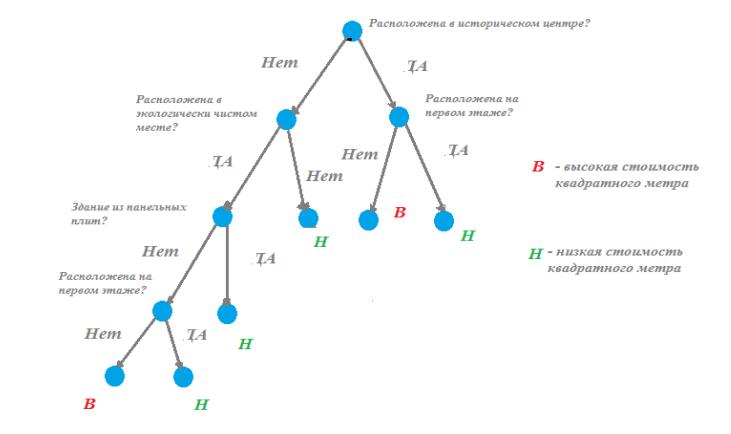

Для датасета смотрится фича, по которой разделяется наибольшее количество образцов, и так каждый раз. В случае, когда используется ensemble, стоится несколько деревьев, каждый из которых является слабым классификатором, но используя принцип голосования, получается хороший классификатор (или регрессор).

Gradient Boosting machine работает сходно с обычным ensemble, но каждое следующее дерево, в отличие от предыдущего случая, используется для того, чтобы улучшить результат работы всего предыдущего набора деревьев.



**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

    :Summary Statistics:

    ===================================== ====== ======
                                           Min    Max
    ===================================== ====== ======
    radius (mean):                        6.981  28.11
    texture (mean):                       9.71   39.28
    perimeter (mean):                     43.79  188.5
    area (mean):                          143.5  2501.0
    smoothness (mean):                    0.053  0.163
    compactness (mean):                   0.019  0.345
    concavity (mean):                     0.0    0.427
    concave points (mean):                0.0    0.201
    symmetry (mean):                      0.106  0.304
    fractal dimension (mean):             0.05   0.097
    radius (standard error):              0.112  2.873
    texture (standard error):             0.36   4.885
    perimeter (standard error):           0.757  21.98
    area (standard error):                6.802  542.2
    smoothness (standard error):          0.002  0.031
    compactness (standard error):         0.002  0.135
    concavity (standard error):           0.0    0.396
    concave points (standard error):      0.0    0.053
    symmetry (standard error):            0.008  0.079
    fractal dimension (standard error):   0.001  0.03
    radius (worst):                       7.93   36.04
    texture (worst):                      12.02  49.54
    perimeter (worst):                    50.41  251.2
    area (worst):                         185.2  4254.0
    smoothness (worst):                   0.071  0.223
    compactness (worst):                  0.027  1.058
    concavity (worst):                    0.0    1.252
    concave points (worst):               0.0    0.291
    symmetry (worst):                     0.156  0.664
    fractal dimension (worst):            0.055  0.208

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from graphviz import Source
import pydotplus
from IPython.display import SVG
import sklearn.ensemble as ensemble
from catboost import CatBoostClassifier 
import shap

C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [3]:
np.random.seed = 12345

X = pd.DataFrame(load_breast_cancer()['data'], columns=load_breast_cancer()['feature_names'])
y = load_breast_cancer()['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

Посмотрим распределение классов. Если классы сильно неравномерно распределены, то, так как функции неравномерно распределены, то модели будет выгоднее предсказывать более частый класс, игнорируя существование второго класса.

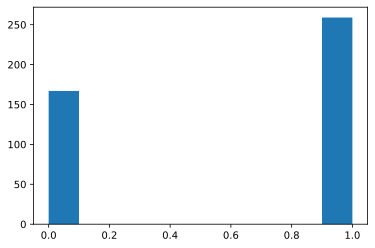

In [4]:
plt.hist(y_train)
plt.show()

In [5]:
def observe(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    def print_metric(y_true, y_pred):
        print(mean_absolute_error(y_true, y_pred), 'MAE')
        print(mean_squared_error(y_true, y_pred), 'MSE')
        print(roc_auc_score(y_true, y_pred), 'ROC-AUC')
        
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metric(y_test, y_pred)
    try:
        dot_data = StringIO()
        export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
        graph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns, class_names=['0', '1'] ,filled = True))
        display(SVG(graph.pipe(format='svg')))
    except Exception:
        pass
    return model

0.06993006993006994 MAE
0.06993006993006994 MSE
0.9189342403628118 ROC-AUC


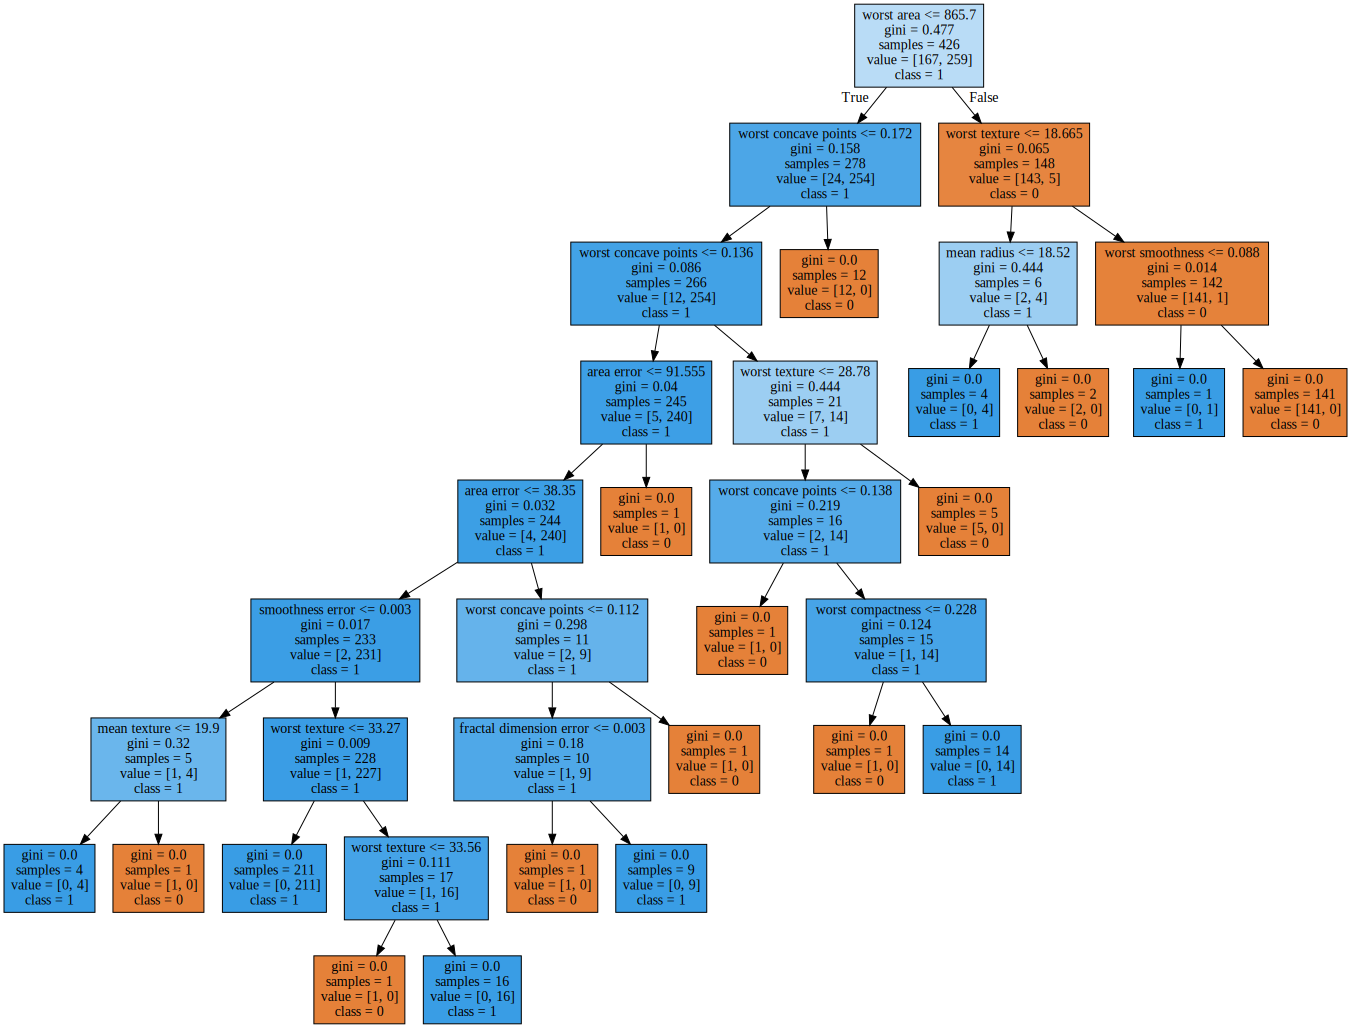

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
observe(tree.DecisionTreeClassifier())

In [7]:
parameters = {'max_depth':list(range(2, 10)), 'class_weight':[{0:1, 1:1}, {0:1.5, 1:1}], 'criterion':['gini', 'entropy']}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
best = clf.best_params_
print(best)


C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 4}


0.06993006993006994 MAE
0.06993006993006994 MSE
0.930952380952381 ROC-AUC


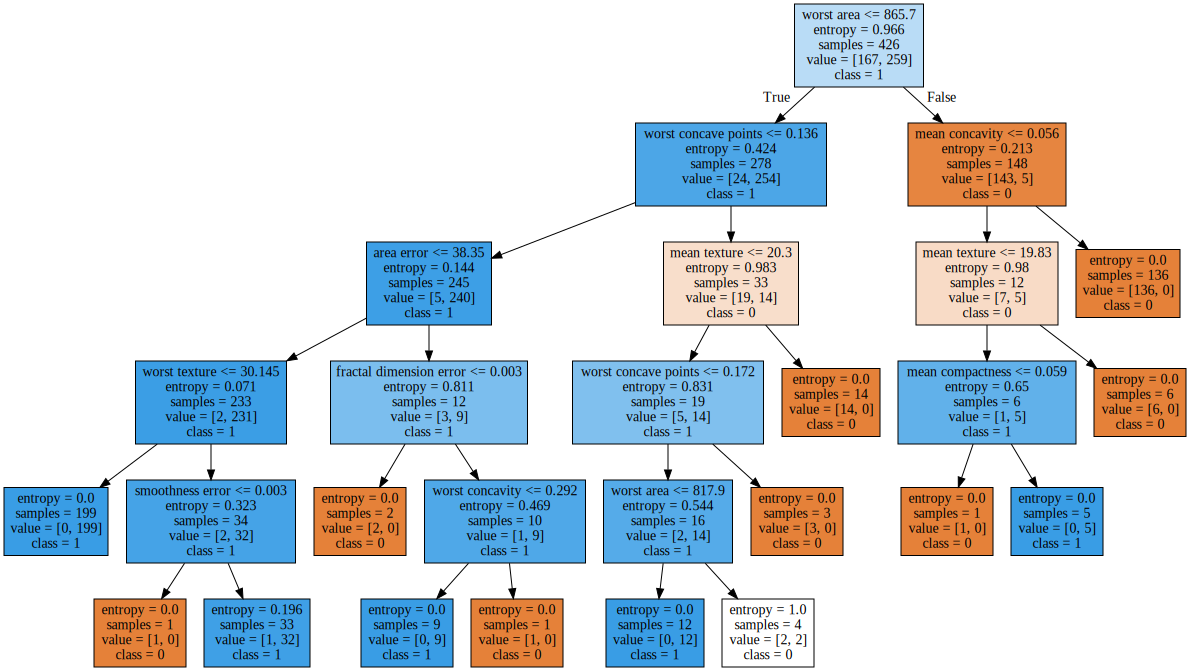

DecisionTreeClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [8]:
observe(tree.DecisionTreeClassifier(class_weight= {0: 1, 1: 1}, criterion= 'entropy', max_depth= 5))

Тут, как можно заметить, подбор оптимальных гиперпараметров, существенно влияет на качество модели. До этого использовалось только одно дерево, сейчас посмотрим, как будет выглядеть результат, елси использовать сразу много деревьев.

In [9]:
observe(ensemble.RandomForestClassifier())

C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.07692307692307693 MAE
0.07692307692307693 MSE
0.9198412698412698 ROC-AUC


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
parameters = {'n_estimators' : list(range(50,100, 5)), 'max_depth': list(range(3,15))}
clf = GridSearchCV(ensemble.RandomForestClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
best = clf.best_params_
print(best)

{'max_depth': 9, 'n_estimators': 70}


In [11]:
observe(clf.best_estimator_)

0.055944055944055944 MAE
0.055944055944055944 MSE
0.941156462585034 ROC-AUC


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
catbst = observe(CatBoostClassifier(verbose = 0))

0.03496503496503497 MAE
0.03496503496503497 MSE
0.9624716553287982 ROC-AUC


В данном ноутбуке дополнительно рассмотрим несколько способов понять, какие фичи имеют значение, а какие почти не вносят вклад в предсказание. Самый простой способ посмотреть на важность фичи в случае решающих деревьев -- посмотреть, сколько раз эта фича учавствовала при разделении дерева. Примеры будем рассматривать на модели Catboost, как на самой прогрессивной из представленных.

Также воспользуемся библиотекой shap, которая в другом смысле показывает важность фичей. Используя терминологию теории игр, смотрится выплата каждому участнику игры (фиче) за его вклад в предсказание. 

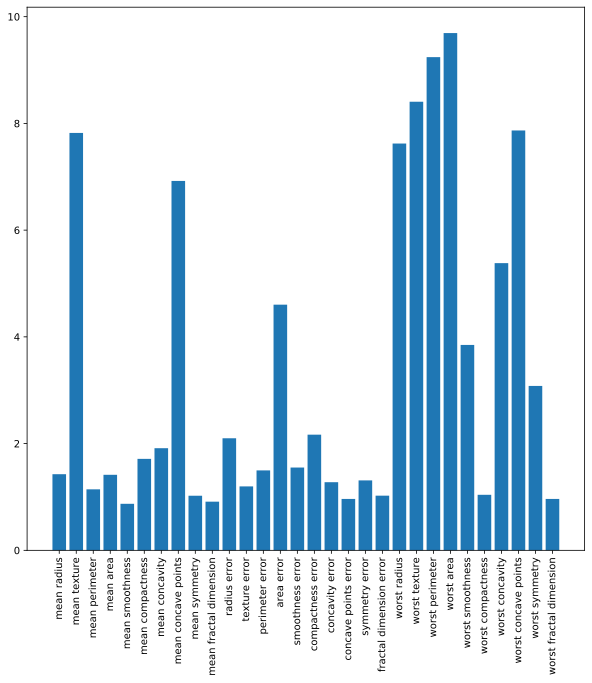

In [19]:
plt.figure(figsize = (10,10))
plt.bar(catbst.feature_names_, catbst.feature_importances_)
plt.xticks(rotation = 'vertical')
plt.show()

In [20]:
import shap 
shap.initjs()

In [21]:
explainer = shap.TreeExplainer(catbst)
shap_values = explainer.shap_values(X_train)

In [22]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

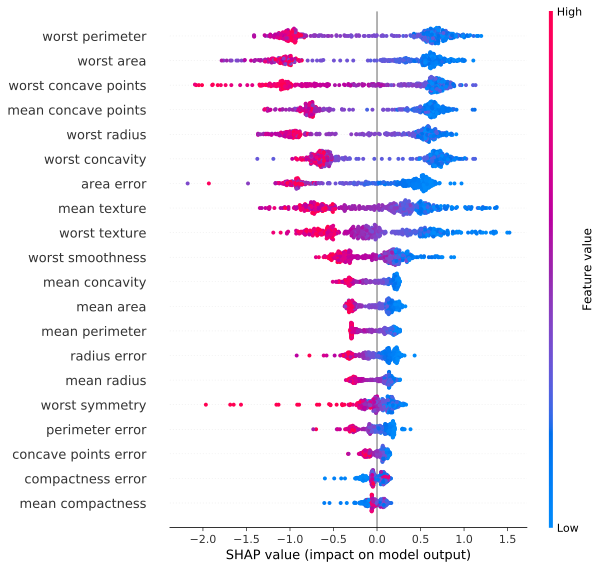

In [23]:
shap.summary_plot(shap_values, X_train)

In [24]:
shap.force_plot(explainer.expected_value, shap_values, X_train)